## Objective: Same scenario debugging

The purpose of this notebook is to align `gpudrive` with `waymax` so that we can reliably use a pre-trained VBD model.

**Notebook sections**

- Configurations
- Load VDB model
- **Waymax** video and distributions
    - Initialize waymax env with debugging scene
    
    - Make video with log-playback trajectories
    - Make video with VBD trajs
    - Feature distributions
- **GPUDrive** video and distributions
    - Initialize GPUDrive env with debugging scene
    - Make video with log-playback trajectories
    - Make video with VBD trajs
    - Feature distributions

----


### Dependencies

In [1]:
%%capture
import waymax
import numpy as np
import math
import mediapy
from tqdm import tqdm
import dataclasses
import os
from pathlib import Path
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from waymax import config as _config
from waymax import dataloader, datatypes, visualization, dynamics
from waymax.datatypes.simulator_state import SimulatorState
from waymax.config import EnvironmentConfig, ObjectType

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

# VBD dependencies
from integrations.models.vbd.sim_agent.waymax_env import WaymaxEnvironment
from integrations.models.vbd.data.dataset import WaymaxTestDataset
from integrations.models.vbd.waymax_visualization.plotting import plot_state
from integrations.models.vbd.sim_agent.sim_actor import VBDTest, sample_to_action
from integrations.models.vbd.model.utils import set_seed

# GPUDrive dependencies
from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv

# Plotting
sns.set("notebook")
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
#%config InlineBackend.figure_format = 'svg'

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

2024-11-09 09:26:01.710657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 09:26:01.717555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 09:26:01.724605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 09:26:01.726724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 09:26:01.732949: I tensorflow/core/platform/cpu_feature_guar

### Configurations

In [2]:
DATA_DIR = 'data/processed' # Base data path
CKPT_DIR = 'data/checkpoints' # Base checkpoint path

SCENARIO_ID = '2bd577a009790706' # Debugging scenario we use 
CKPT_PATH = 'integrations/models/vbd/weights/epoch=18.ckpt'

FPS = 20
INIT_STEPS = 11 # Warmup period
MAX_CONTROLLED_OBJECTS = 32

### Load pre-trained VBD model

In [10]:
# Load model
model = VBDTest.load_from_checkpoint(CKPT_PATH, torch.device('cpu'))
_ = model.cuda()
_ = model.eval();

# Model settings
replan_freq=80 # Roll out every X steps 80 means openloop
model.early_stop=0 # Stop Diffusion Early From 100 to X
model.skip = 1 # Skip Alpha 
model.reward_func = None

# Ensure reproducability
#set_seed(5)

### **Waymax** video and distributions

#### Initialize waymax env with debugging scene

In [4]:
env_config = EnvironmentConfig(
    controlled_object=ObjectType.VALID,
    allow_new_objects_after_warmup=False,
    init_steps=INIT_STEPS+1,
    max_num_objects=MAX_CONTROLLED_OBJECTS,
)

waymax_env = WaymaxEnvironment(
    dynamics_model=dynamics.StateDynamics(),
    config=env_config,
    log_replay = True,
)

scenario_path = os.path.join(DATA_DIR, SCENARIO_ID + '.pkl')
with open(f'{DATA_DIR}/debug/waymax/waymax_scenario_{SCENARIO_ID}_max_{MAX_CONTROLLED_OBJECTS}.pkl', 'rb') as f:
    scenario = pickle.load(f)
    
# Create "dataset" (need for utils)
dataset = WaymaxTestDataset(
    data_dir = 'data/processed/debug/waymax', 
    anchor_path = 'integrations/models/vbd/data/cluster_64_center_dict.pkl',
    max_object=MAX_CONTROLLED_OBJECTS,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Found 2 scenarios


#### Make video with log-playback trajectories

- As a sanity check, we first look at the replayed human trajectories 

""

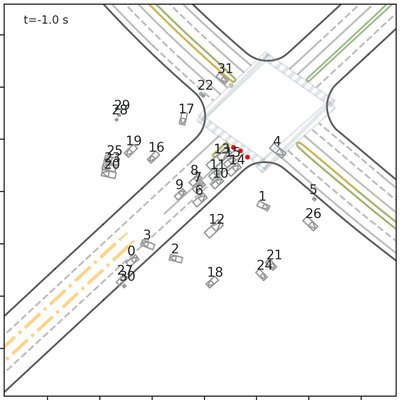

In [5]:
scenario.sim_trajectory = scenario.log_trajectory

log_playback_imgs = []
for t in range(scenario.remaining_timesteps):
  scenario.timestep = t
  log_playback_imgs.append(plot_state(scenario))

mediapy.show_video(log_playback_imgs, codec='gif', fps=FPS)

In [6]:
mediapy.write_video(f"logged_waymax_trajs_{SCENARIO_ID}.gif", log_playback_imgs, codec='gif', fps=FPS)

#### Make video with VBD trajectories (unguided)



In [7]:
# Reset 
init_state = waymax_env.reset(scenario)

# Process the scenario
current_state = init_state
sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)
is_controlled = sample['agents_interested'] > 0
selected_agents = sample['agents_id'][is_controlled]

print(f'controlling agents: {selected_agents}')

state_logs = [current_state]

for i in range(current_state.remaining_timesteps):
    t = i % replan_freq
    if t == 0:
        print("Replan at ", current_state.timestep)
        sample = dataset.process_scenario(
          current_state, 
          current_index = current_state.timestep,
          use_log=False,
          selected_agents=selected_agents, # override the agent selection by distance to the ego
        )
        batch = dataset.__collate_fn__([sample])
        pred = model.sample_denoiser(batch)
        traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

    # Get action
    action_sample = traj_pred[:, t, :]
    action = sample_to_action(
      action_sample, 
      is_controlled, 
      agents_id=selected_agents, 
      max_num_objects=MAX_CONTROLLED_OBJECTS
    )
    # Step the simulator
    current_state = waymax_env.step_sim_agent(current_state, [action])
    state_logs.append(current_state)

vbd_waymax_imgs = [plot_state(state) for state in state_logs]

controlling agents: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
Replan at  11


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 30.39it/s]


---

> ### Observations from watching a couple of VBD-generated traj videos:

- **Pro**: Generated trajectories are smooth and human-like
- **Pro**: Vehicles do not collide with road edges
- **Limitation**: Trajectories often "drive through" other vehicles
- **Limitation**: Vehicles sometimes drive through road edges*

---

""

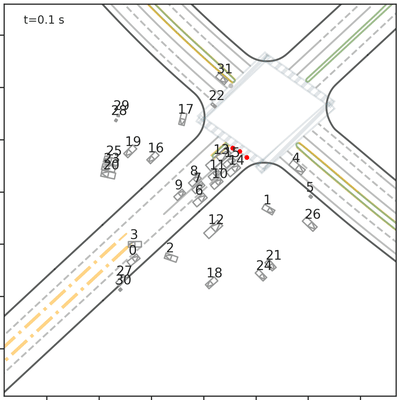

In [7]:
mediapy.show_video(vbd_waymax_imgs, codec='gif', fps=FPS)

In [8]:
mediapy.write_video(f"vbd_waymax_trajs_{SCENARIO_ID}.gif", vbd_waymax_imgs, codec='gif', fps=FPS)

#### Save waymax input + output features


In [9]:
init_state = waymax_env.reset(scenario)

print(f'Steps remaining: {init_state.remaining_timesteps}')

waymax_vbd_sample = dataset.process_scenario(
  init_state,
  current_index=init_state.timestep,
  use_log=False
)

# Save predicted trajectories
waymax_vbd_sample['pred_denoised_trajs'] = pred['denoised_trajs']

# # Save dictionary for further inspection
# with open(f'waymax_vbd_sample_{SCENARIO_ID}.pkl', 'wb') as f:
#     pickle.dump(waymax_vbd_sample, f)
    
#plot_batch_distributions(waymax_vbd_sample, title='Waymax ', timestep=int(init_state.timestep), dist_type='box_plot')

Steps remaining: 79


### **GPUDrive** video and distributions

#### Initialize GPUDrive env with debugging scene

In [3]:
env_config = EnvConfig(
    init_steps=INIT_STEPS, # Warmup period
    remove_non_vehicles=False, # Control vehicles, pedestrians, and cyclists
    return_vbd_data=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
    dist_to_goal_threshold=1e-5, # Trick to make sure the agents don't disappear when they reach the goal
    collision_behavior="ignore", # Ignore collisions|
)

# Make env
gpudrive_env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=SceneConfig(path="data/processed/debug/gpudrive", num_scenes=1),
    render_config=RenderConfig(draw_obj_idx=True, render_init=True, resolution=(650, 650)),
    max_cont_agents=MAX_CONTROLLED_OBJECTS, # Maximum number of agents to control per scene
    device="cpu",
)


--- Ratio unique scenes / number of worls =         1 / 1 ---



#### Make video with log-playback trajectories

- As a sanity check, we first look at the replayed human trajectories 
- Note that only 3 agents are actually moving, the rest of the vehicles are static

In [4]:
gpudrive_env.get_expert_actions().shape

torch.Size([1, 32, 91, 10])

In [5]:
init_state = gpudrive_env.reset()

log_playback_traj = gpudrive_env.get_expert_actions()

gpudrive_log_playback_frames = []

for t in range(env_config.episode_len-(INIT_STEPS+1)):
     
    # Step
    gpudrive_env.step_dynamics(log_playback_traj[:, :, t, :]) 

    # Render: rotate 180 degrees because waymax frames are flipped
    gpudrive_log_playback_frames.append(np.rot90(gpudrive_env.render(), k=3))

---

> **Note: Passes sanity check. ✅** This is exactly the same as the one in Waymax 

---

GPUDrive with log-playback trajectories

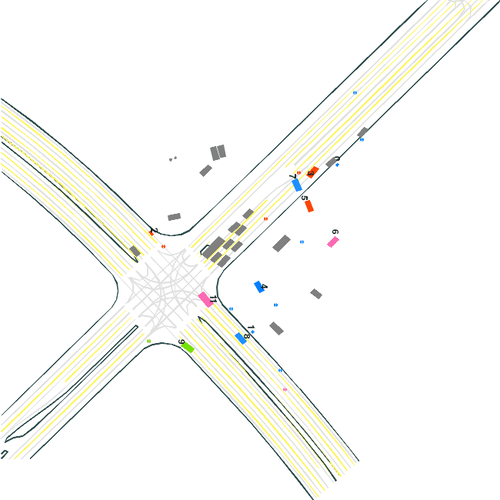

In [6]:
mediapy.show_video(gpudrive_log_playback_frames, codec='gif', title='GPUDrive with log-playback trajectories', width=500)

In [7]:
mediapy.write_video(f"logged_gpudrive_trajs_{SCENARIO_ID}_rot90.gif", gpudrive_log_playback_frames, codec='gif', fps=FPS)

#### Make video with VBD trajectories (unguided)

In [15]:
# Reset env with warmup period 
init_state = gpudrive_env.reset()

selected_agents = torch.nonzero(gpudrive_env.cont_agent_mask[0, :]).flatten().tolist()

print(f"Controlling {len(selected_agents)} agents: {selected_agents}")

# Obtain all info for diffusion model (warmup)
gpudrive_sample_batch = gpudrive_env.sample_batch

# Obtain predicted trajectories
pred = model.sample_denoiser(gpudrive_sample_batch)#, x_t=x_t)
vbd_traj_pred = pred['denoised_trajs'].cpu().numpy()[0]

is_controlled = gpudrive_sample_batch['agents_interested'] > 0

Controlling 11 agents: [0, 3, 4, 9, 10, 16, 18, 23, 27, 28, 31]


Diffusion: 100%|██████████| 50/50 [00:01<00:00, 31.79it/s]


In [16]:
# Our sim expects a 10D action with the state dynamics model
# (x, y, z, yaw, vel x, vel y, vel z, ang_vel_x, ang_vel_y, ang_vel_z)
# (0, 1, 2, 3,     4,   5,    6,        7,         8,         9)

pred_trajs = torch.zeros((MAX_CONTROLLED_OBJECTS, env_config.episode_len-INIT_STEPS, 10))
pred_trajs[:, :, 0:2] = torch.Tensor(vbd_traj_pred[:, :, 0:2]) # pos x, y
pred_trajs[:, :, 3] = torch.Tensor(vbd_traj_pred[:, :, 2]) # yaw 
pred_trajs[:, :, 4:6] = torch.Tensor(vbd_traj_pred[:, :, 3:5]) # vel x, y
pred_trajs = pred_trajs.unsqueeze(0)

print(f'Rolling out from t = {gpudrive_env.step_in_episode} to t = {env_config.episode_len}')

frames = []

# Step
for t in range(env_config.episode_len-(INIT_STEPS+1)):
    
    gpudrive_env.step_dynamics(pred_trajs[:, :, t, :])

    frames.append(np.rot90(gpudrive_env.render(), k=3))

Rolling out from t = 11 to t = 91


---

> ### Observations:
- Good: Trajectories look smooth/human-like similar to those in Waymax
- Problem: Vehicles drive through road edges (why?)
---

GPUDrive with VBD-trajs

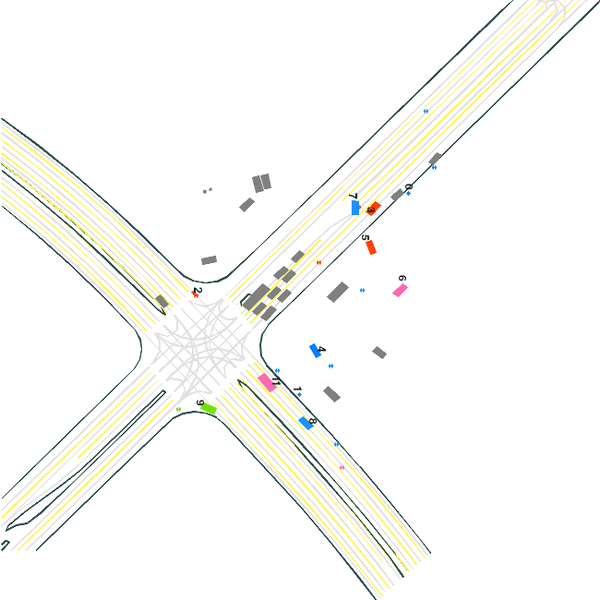

In [17]:
mediapy.show_video(frames, codec='gif', title='GPUDrive with VBD-trajs', width=600, fps=FPS)

In [19]:
mediapy.write_video(f"vbd_gpudrive_trajs_{SCENARIO_ID}_after_yaw_fix_1109.gif", frames, codec='gif', fps=FPS)

#### Save GPUDrive input + output features

In [23]:
def to_numpy(d):return {k: v.cpu().numpy() for k, v in d.items()}

gpudrive_sample_batch_np = to_numpy(gpudrive_sample_batch)

# Save VBD predicted trajectories
gpudrive_sample_batch_np['pred_denoised_trajs'] = pred['denoised_trajs']

# Save as pickle 
with open(f'gpudrive_vbd_sample_{SCENARIO_ID}.pkl', 'wb') as f:
    pickle.dump(gpudrive_sample_batch_np, f)